In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
stop = stopwords.words('english')

# Pre-Processing:
    Approach:
    - Read data from CSV into a dataframe
    - Remove false links (56 in total, 0.4% of all data)
    - Lowercase all string type columns and convert any large white spaces to a single space

In [2]:
# Read in csv
df = pd.read_csv('serious_eats_recipes.csv')

#  Drop empty cuisine column
try:
    df = df.drop(['cuisine'], axis=1)
except:
    pass

# Original Metadata
metadf = pd.DataFrame()
metadf['Num_Values']=df.count()
metadf['Missing_Values'] = df.isnull().sum()
metadf['%Missing'] = df.isnull().sum()/len(df)*100

# Drop the 56 rows with no recipe titles: links are menus, not recipes
df = df.dropna(subset=['title'])

# Reset indices after removing fake recipes
df.index = list(range(0,12620))

#  Make a copy to test code
copydf =df.copy()

# Change all text columns to lowercase
df = df.applymap(lambda s:s.lower() if type(s) == str else s)

# Strip '/' from topic column
df['topic'] = df.topic.str.strip('/')

# Replace all empty spaces with a singular space
# \s+ means all empty space (\n, \r, \t)
df = df.applymap(lambda s: re.sub('\s+', ' ', s) if type(s) == str else s)


### Has the popularity of recipes changed over time?
    Approach:
        1. Plot the number of ratings per year up to the end of 2019
        2. Plot average and median ratings by year

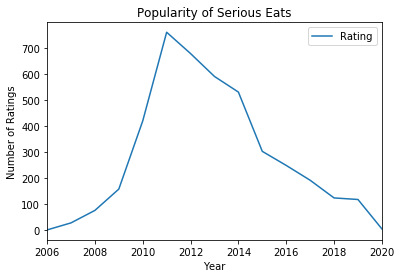

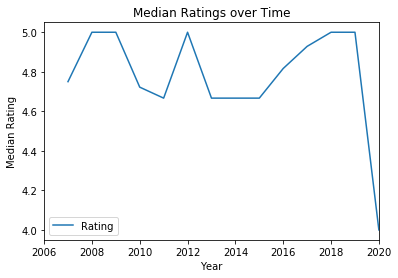

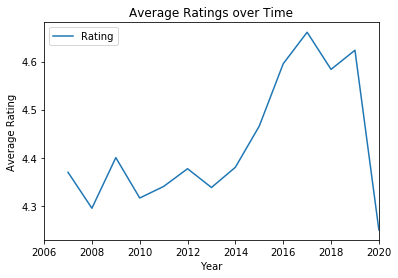

In [3]:
time_df = pd.DataFrame()
time_df['Date'] = pd.to_datetime(df['pub_date'])
time_df['Rating'] = df['rating']
time_df = time_df.sort_values('Date').set_index('Date')


time_df.groupby(time_df.index.year).count().plot()
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.title('Popularity of Serious Eats')
plt.savefig('num_ratings_timeseries.pdf', dpi=300, bbox_inches='tight')


median_ratings_timecourse = time_df.groupby(time_df.index.year).median().plot()
plt.xlabel('Year')
plt.ylabel('Median Rating')
plt.title('Median Ratings over Time')
plt.savefig('median_ratings_timeseries.pdf', dpi=300, bbox_inches='tight')

avg_ratings_timecourse = time_df.groupby(time_df.index.year).mean().plot()
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.title('Average Ratings over Time')
plt.savefig('avg_ratings_timeseries.pdf', dpi=300, bbox_inches='tight')

### Conclusions

Serious Eats popularity peaked in 2011 after it received two James Beard Awards.

Rating data suggests that usership is declining despite content quality staying high


A main goal for SeriousEats.com should therefore be to gain more users. This can be achieved by generating new content and building useful features.



### Are some authors more successful than others?

Highly-rated authors should be selected to generate high quality content to attract new users.

Approach:
    1. Get list of unique authors
    2. Determine number of recipes per author and rating statistics using the groupby function
    3. Plot distribution of recipes written per author
    4. Plot Average Rating per author  vs Recipe Number or Number of Ratings


Number of Authors: 225


C:\Users\Zefa\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


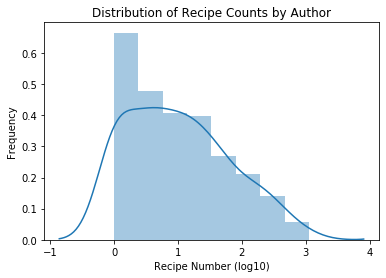

In [4]:
# Get list of authors (225)
print("Number of Authors: " + str(len(set(df['author']))))
author_list = list(set(df['author']))

# Group by author and determine number of recipes, average and median ratings along 
col_fun = {'link':['count'], 'rating': ['mean', 'median', 'count', 'std']}
author_stats = df.groupby('author').agg(col_fun)

author_stats.columns = ['recipe_number', 'avg_rating','median_rating', 'num_ratings', 'rating_std']

author_stats.sort_values(by='recipe_number', ascending=False, inplace=True)
author_stats['log10_num_ratings'] = np.log10(author_stats['num_ratings'])

# Plot number of recipes per author in log10
sns.distplot(np.log10(author_stats['recipe_number']))
plt.xlabel('Recipe Number (log10)')
plt.ylabel('Frequency')
plt.title('Distribution of Recipe Counts by Author')
plt.savefig('recipe_num_distribution.pdf', dpi=300, bbox_inches='tight')

C:\Users\Zefa\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Zefa\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


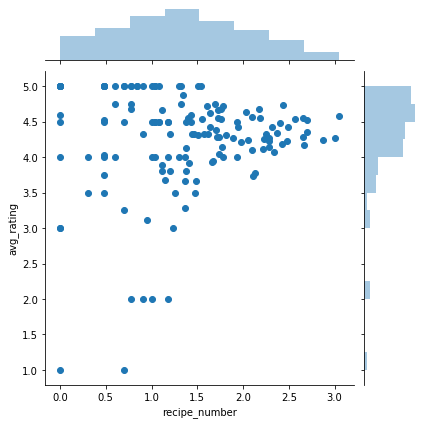

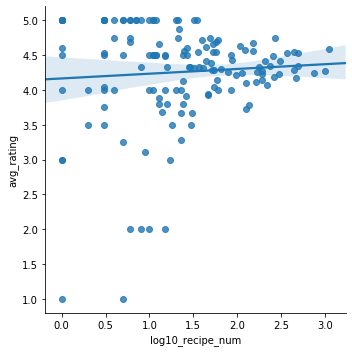

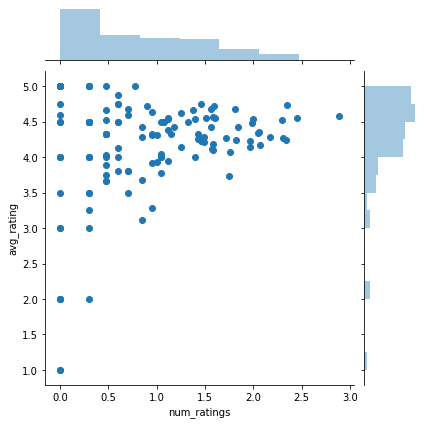

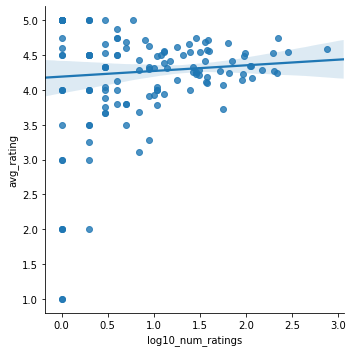

In [5]:
# Look at subset of authors who are rated (147/225 or 65.3%)
rated_author_stats = author_stats.dropna(subset=['avg_rating'])
num_rated_authors = len(rated_author_stats)
rated_author_stats['log10_recipe_num'] = np.log10(rated_author_stats['recipe_number'])

# Plot avg rating by recipe number
my_plot = sns.jointplot(x=np.log10(author_stats['recipe_number']), y="avg_rating", data=author_stats)
plt.savefig('avg_rating_recipe_count.pdf', dpi=300, bbox_inches='tight')

sns.lmplot('log10_recipe_num', 'avg_rating', rated_author_stats)
plt.savefig('avg_rating_recipe_count_lm.pdf', dpi=300, bbox_inches='tight')


# Plot avg rating vs rating number
sns.jointplot(x=np.log10(author_stats['num_ratings']), y=author_stats['avg_rating'])
plt.savefig('avg_rating_ratings_count.pdf', dpi=300, bbox_inches='tight')

sns.lmplot('log10_num_ratings', 'avg_rating', rated_author_stats)
plt.savefig('avg_rating_ratings_count_lm.pdf', dpi=300, bbox_inches='tight')

# Plot median rating vs rating number with or without log10 transformation
# sns.jointplot(x=np.log10(author_stats['num_ratings']), y=author_stats['median_rating'])
# sns.jointplot(x=author_stats['num_ratings'], y=author_stats['median_rating'])



### Conclusions
    
Authors who have written 30+ recipes have higher average ratings than less prolific authors. 

New content should be generated by authors who have written more than 30 recipes.

### What type of new content should be generated?

Approach:
    - Group recipes by topics (cuisine, ingredient, meal, method)
    - Determine the number of recipes per subtopic
    - Compare ratings across subtopics

In [6]:
# Get the number of recipes and number of unique subtopics per topic

print("Number of subtopics: " + str(len(set(df['subtopic']))))

subtopic_set_list= list(df.groupby('topic').agg(lambda x: set(x))['subtopic'])

topic_list = ['cuisine', 'ingredient', 'meal', 'method']

num_subtopics = []
i=0
while i < len(subtopic_set_list):
    num_subtopics.append(len(subtopic_set_list[i]))
    i+=1
               
num_recipes_bytopic = list(df.groupby('topic').count()['link'])    
topic_stats = list(zip(topic_list,num_recipes_bytopic, num_subtopics))
topic_stats

Number of subtopics: 200


[('cuisine', 474, 19),
 ('ingredient', 8250, 101),
 ('meal', 3573, 67),
 ('method', 323, 13)]

C:\Users\Zefa\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


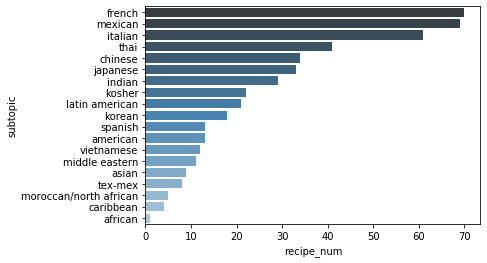

In [7]:
#  Plot number of recipes per cuisine

recipes_by_subtopic = df.groupby(['topic', 'subtopic'], as_index=False).agg({'link': 'count', 'rating': ['mean', 'median', 'count', 'std']})

cuisine_subdf= recipes_by_subtopic[recipes_by_subtopic['topic']=='cuisine']
cuisine_subdf.columns = ['topic', 'subtopic', 'recipe_num', 'avg_rating', 'median_rating', 'num_ratings', 'std_ratings']
cuisine_subdf.sort_values(by='recipe_num', ascending = False, inplace=True)

sns.barplot(x=cuisine_subdf['recipe_num'], y=cuisine_subdf['subtopic'], data = cuisine_subdf[['recipe_num', 'subtopic']],palette="Blues_d" )
plt.savefig('num_recipes_per_cuisine.pdf', dpi=300, bbox_inches='tight')



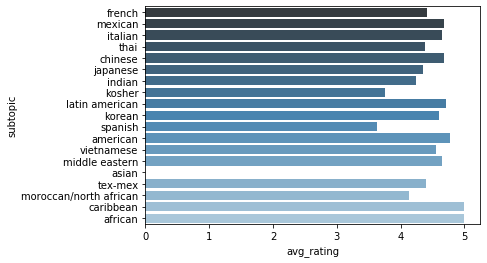

In [8]:
# Plot average rating by cuisine
sns.barplot(x=cuisine_subdf['avg_rating'], y=cuisine_subdf['subtopic'], 
            data = cuisine_subdf[['avg_rating', 'subtopic', 'std_ratings']], palette="Blues_d")
plt.savefig('avg_rating_per_cuisine.pdf', dpi=300, bbox_inches='tight')

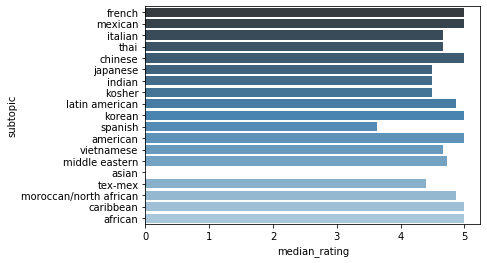

In [9]:
# Plot median rating per cuisine
sns.barplot(x=cuisine_subdf['median_rating'], y=cuisine_subdf['subtopic'], 
            data = cuisine_subdf[['median_rating', 'subtopic', 'std_ratings']], palette="Blues_d")
plt.savefig('median_rating_per_cuisine.pdf', dpi=300, bbox_inches='tight')

### Conclusions

There are very few caribbean and african recipes but they are highly rated. 

Generating more of these recipes could draw more users.

### What features are correlated with recipe success?

Extract numeric features

Calculate pearson correlation with rating


In [10]:
# Calculate length of recipe titles as the number of characters in the title
df['title_length_chars'] = df['title'].apply(len)


#### Identify unique ingredients and their amounts for each recipe


- Split large ingredient string into a substring for each ingredient for each recipe
- Search for the pattern: anything but an empty space then comma then anything but an empty space
- Keep the first part of the giant string up until the match then search the rest of the string until no more matches


In [11]:
def split_(giant_str):
    giant_str = str(giant_str)
    result_lis = []
                   
    while True:
        match = re.search('[^ ],[^ ]', giant_str)
        
        if match == None:
            result_lis.append(giant_str)
            break
            
        result_lis.append(giant_str[: match.span()[1]-2])
        giant_str = giant_str[match.span()[1]-1:]

    return result_lis


# Test cases for split_()

temp_ingred = df['ingredients']
one_ingred = temp_ingred[0]

test_str1 = '1 cup plus 1 tablespoon (250ml) canola or vegetable oil, divided,6 boneless, skinless chicken thighs'
expect_1 = ['1 cup plus 1 tablespoon (250ml) canola or vegetable oil, divided', '6 boneless, skinless chicken thighs']
obs_1 = split_(test_str1)
print(expect_1==obs_1)


test_str2 = '1 cup plus 1 tablespoon (250ml) canola or vegetable oil, divided'
expect_2= ['1 cup plus 1 tablespoon (250ml) canola or vegetable oil, divided']
obs_2 = split_(test_str2)
print(expect_2==obs_2)

test_str3 = '1 cup plus 1 tablespoon (250ml) canola or vegetable oil, divided,6 boneless, skinless chicken thighs (about 2 1/4 pounds; 1kg total),kosher salt,1 1/2 pounds cajun-style andouille sausage'
expect_3= ['1 cup plus 1 tablespoon (250ml) canola or vegetable oil, divided', '6 boneless, skinless chicken thighs (about 2 1/4 pounds; 1kg total)','kosher salt','1 1/2 pounds cajun-style andouille sausage']
obs_3 = split_(test_str3)
print(expect_3==obs_3)


# Iterate through all strings in ingredients column
#  Output: clean_ingredients, A nested list containing individual ingredients split for each recipe 
#  [['ing1', 'ing2', 'ing3'], ['ing1', 'ing2', 'ing3'], etc]

clean_ingredients = []
for i in temp_ingred:
    clean_ingredients.append(split_(i))

    
# Count the number of unique ingredients per recipe and store in num_ingredients list
num_ingredients =[]
for clean_ingredient in clean_ingredients:
    num_ingredients.append(len(clean_ingredient))
 
    
    
# Check if order of clean_ingredients matches order of df (MUST RESET INDICES AFTER DROPPING ROWS)
# print("Df: " + df['ingredients'][0])  
# print('='*50)
# print("Clean_ingredient: " + str(clean_ingredients[0]))
# print('='*50)
# print("Num ingredients: " + str(num_ingredients[0]))
    

True
True
True


In [12]:
# Add num_ingredients as a new column to df
df['num_ingredients'] = pd.Series(num_ingredients)

# Update ingredients column with separated ingredients
df['ingredients'] = pd.Series(clean_ingredients)


For each recipe, identify the measure (Example: 1 cup) and name of each ingredient

Save as a nested list called parse_list

Adapted from: https://bitbucket.org/phoodster/ingredient-parser/src/master/

In [13]:
import re
from itertools import chain

SEPARATOR_RE = re.compile(r'^([\d\s*[\d\.,/]*)\s*(.+)')

def normalize(st):
    """

    :param st:
    :return:
    """
    return re.sub(r'\s+', ' ', SEPARATOR_RE.sub('\g<1> \g<2>', st)).strip()

def escape_re_string(text):
    """

    :param text:
    :return:
    """
    text = text.replace('.', '\.')
    return re.sub(r'\s+', ' ', text)


UNITS = {"cup": ["cups", "cup", "c.", "c"], "fluid_ounce": ["fl. oz.", "fl oz", "fluid ounce", "fluid ounces"],
         "gallon": ["gal", "gal.", "gallon", "gallons"], "ounce": ["oz", "oz.", "ounce", "ounces"],
         "pint": ["pt", "pt.", "pint", "pints"], "pound": ["lb", "lb.", "pound", "pounds"],
         "quart": ["qt", "qt.", "qts", "qts.", "quart", "quarts"],
         "tablespoon": ["tbsp.", "tbsp", "T", "T.", "tablespoon", "tablespoons", "tbs.", "tbs"],
         "teaspoon": ["tsp.", "tsp", "t", "t.", "teaspoon", "teaspoons"],
         "gram": ["g", "g.", "gr", "gr.", "gram", "grams"], "kilogram": ["kg", "kg.", "kilogram", "kilograms"],
         "liter": ["l", "l.", "liter", "liters"], "milligram": ["mg", "mg.", "milligram", "milligrams"],
         "milliliter": ["ml", "ml.", "milliliter", "milliliters"], "pinch": ["pinch", "pinches"],
         "dash": ["dash", "dashes"], "touch": ["touch", "touches"], "handful": ["handful", "handfuls"],
         "stick": ["stick", "sticks"], "clove": ["cloves", "clove"], "can": ["cans", "can"], "large": ["large"],
         "small": ["small"], "scoop": ["scoop", "scoops"], "filets": ["filet", "filets"], "sprig": ["sprigs", "sprig"]}

NUMBERS = ['seventeen', 'eighteen', 'thirteen', 'nineteen', 'fourteen', 'sixteen', 'fifteen', 'seventy', 'twelve',
           'eleven', 'eighty', 'thirty', 'ninety', 'twenty', 'seven', 'fifty', 'sixty', 'forty', 'three', 'eight',
           'four', 'zero', 'five', 'nine', 'ten', 'one', 'six', 'two', 'an', 'a']

prepositions = ["of"]

a = list(chain.from_iterable(UNITS.values()))
a.sort(key=lambda x: len(x), reverse=True)
a = map(escape_re_string, a)

PARSER_RE = re.compile(
    r'(?P<quantity>(?:[\d\.,][\d\.,\s/]*)?\s*(?:(?:%s)\s*)*)?(\s*(?P<unit>%s)\s+)?(\s*(?:%s)\s+)?(\s*(?P<name>.+))?' % (
        '|'.join(NUMBERS), '|'.join(a), '|'.join(prepositions)))


def parse(st):
    """

    :param st:
    :return:
    """
    st = normalize(st)
    res = PARSER_RE.match(st)

    return {
        'measure': (res.group('quantity') or '').strip() + ' ' + (res.group('unit') or '').strip(),
        'name': (res.group('name') or '').strip()
    }



parse_list = [[parse(y) for y in x] for x in clean_ingredients]


#### Identify number of steps per recipe

Count number of sentences in the directions

Count the number of words in the directions

In [14]:
# Determine the length of the directions
# Save copy of raw directions
raw_directions = df['directions']

# Method 1: Number of sentences
len(df['directions'][0].split('. '))

# Method 2: Number of words
len(df['directions'][0].split(' '))


# Tests for directions
# print("Raw Directions: " + df['directions'][1250])
# print('='*50)
# print("Number of sentences: " + str(len(df['directions'][1250].split('. '))))
# print('='*50)
# print("Number of words: " + str(len(df['directions'][1250].split(' '))))
# print('='*50)
# print(df['directions'][0].split(' '))

dir_num_sentences =[]
dir_num_words = []

for i in df['directions']:
    dir_num_sentences.append(len(str(i).split('. ')))
    dir_num_words.append(len(str(i).split(' ')))


Count the number of words in the ingredients

In [15]:

# Number of words in ingredients
ingr_num_words =[]

for i in df['ingredients']:
    ingr_num_words.append(len(str(i).strip(',').split(' ')))



In [16]:
# Add three new columns to df_text: directions_num_sentences, directions_num_words, ingredients_num_words

df['directions_num_sentences'] = pd.Series(dir_num_sentences)
df['directions_num_words'] =pd.Series(dir_num_words)
df['ingredients_num_words'] =pd.Series(ingr_num_words)


In [17]:
# Calculate the Pearson correlation coefficient of the numerical data extracted

df.corr(method='pearson')['rating'].sort_values(ascending=False)


rating                      1.000000
ingredients_num_words       0.066926
title_length_chars          0.060753
num_ingredients             0.021316
directions_num_words        0.021097
directions_num_sentences    0.004784
Name: rating, dtype: float64

#### Conclusion

A simple Pearson correlation does not reveal any strong relationships between recipe success and the collected numeric features. 

Future work could focus on converting other text data (servings, active and total times) into numerical format to test for correlations. 

More advanced machine learning techniques may be helpful to identify important features of successful recipes.


### Development of a Search Tool to Attract More Users

People have very little free time and it can be hard to decide what to eat after a long day at work. 
    
Serious Eats can leverage their dataset to build a recipe suggestion tool to make it easier on users. 

In [19]:
# Save a list of all ingredients in a recipe as one string
string_ingredients = []
for i in df['ingredients']:
    string_ingredients.append(' '.join(i).strip(','))


# Remove stopwords from ingredients 
new_string_ingredients = list(map(lambda text: " ".join(word for word in text.split() if word not in stop).strip(','), string_ingredients))

# Create dictionary of links: ingredient strings to pass into method
# lemmatize, strip numbers, make a set

links = df['link']

link2ingredient = {}

for link, ingredient_string in zip(links, new_string_ingredients):
    link2ingredient[link] = " ".join(set(ingredient_string.replace(',','').split(' ')))
    


In [20]:
# Select a recipe given a list of ingredients using cosine similarity

import importlib
import cosine_similarity_ingredients
importlib.reload(cosine_similarity_ingredients)


ingredient_classifier = cosine_similarity_ingredients.IngredientClassifier(link2ingredient)


In [21]:
# Ask the user for a list of ingredients and return a link to the closest matching recipe

user_query = input("What ingredients would you like to use? ")

suggestion = ingredient_classifier.query(user_query.lower(), normalized = True)
print("You may like : " + suggestion)


What ingredients would you like to use? cucumber soy sauce garlic
You may like : https://www.seriouseats.com/recipes/2011/04/turmeric-coconut-chicken-and-rice-recipe.html


In [ ]:
# Export cleaned dataframe

df.to_csv('Serious_Eats_cleaned_data.csv', index=False)